# Mesoscale Eddies

The notebook includes all calculations regarding eddy detection statistics (chapter 3.1.1), eddy kinetic energy (chapter 3.1.2) and the density anomaly of mesoscale eddies (chapter 3.1.2). The following figures are created in this notebook:
- Figure 3.1: Distribution of eddy radius
- Figure 3.2: Ratio of cyclonic to anticyclonic tracks
- Figure 3.3: Eddy Kinetic Energy
- Figure 3.5: Offshore density anomaly
- Figure 3.6: Relative increase in offshore EKE
- Figure A.8: Eddy radius with distance from coast
- Figure A.10: Offshore density anomaly (increased depth range)

In [1]:
import sys
sys.path.append('/nfs/kryo/work/maxsimon/master-thesis/scripts')

import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

from romstools.romsrun import RomsRun
from romstools.psd import get_dist, prepare_axis_for_psd, plot_single_psd, do_multidim_welch, binned_mean, do_complex_time_welch
from romstools.utils import get_depth_dim
from romstools.plot import plot_data
from romstools.utils import get_area_map, np_rolling_mean
from romstools.cmap import W2G, DIFF_r
from romstools.utils import p, cache, get_doys, mean_with_error, ratio_with_error

import scipy.signal as sig
import scipy.stats as stat
from scipy.ndimage import generic_filter1d, gaussian_filter

import cartopy.crs as ccrs

import warnings
from datetime import timedelta as tdelta

import matplotlib.animation as animation
from matplotlib import rc
from matplotlib.cm import get_cmap
from collections import defaultdict

In [2]:
def area_to_radius(area):
    # calculate radius from area
    return np.sqrt(area/np.pi)

def radius_to_area(radius):
    # calculate area from radius
    return np.pi * (radius ** 2) * np.sign(radius)

## Load Data

In [3]:
# define names for runs
NAMES = {
    'pactcs15': 'HR',
    'pactcs30': 'MR',
    'pactcs15_30': 'HR interpolated'
}

# define order for processing and plotting
ORDER = ['pactcs30', 'pactcs15']


# load data
runs = {}
runs_grid = {}
runs_grid_data = {}
runs_ke = {}
runs_rho = {}
runs_rho2 = {}

for run in ORDER:
    # load eddy detections
    runs[run] = xr.open_dataset('/nfs/kryo/work/maxsimon/data/'+run+'/ssh/eddies-00000.nc')
    # load grid data
    runs_grid[run] = xr.open_dataset('/nfs/kryo/work/maxsimon/data/'+run+'/grid.nc')
    runs_grid_data[run] = np.load('/nfs/kryo/work/maxsimon/data/'+run+'/grid.npz', allow_pickle=True)
    # load eddy kinetic energy
    runs_ke[run] = xr.open_dataset('/nfs/kryo/work/maxsimon/data/'+run+'/ssh/ano/final_eke_surface-00000.nc')
    # load density anomaly (depth range 80 - 120m)
    runs_rho[run] = xr.open_dataset('/nfs/kryo/work/maxsimon/data/'+run+'/ssh/ano/final_rho_18to25-00000.nc')
    # load density anomaly (depth range 20 - 200m)
    runs_rho2[run] = xr.open_dataset('/nfs/kryo/work/maxsimon/data/'+run+'/ssh/ano/final_rho_7to33-00000.nc')

In [4]:
# load the interpolated ssh field
runs['pactcs15_30'] = xr.open_dataset('/nfs/kryo/work/maxsimon/data/pactcs30/ssh_152/eddies-00000.nc')

### Rearrange data

In [5]:
# reorder grid related stuff

r_gruber_mask = {
    name: runs_grid_data[name]['gruber_mask'] for name in runs_grid_data
}

r_distance_lines = {
    name: runs_grid_data[name]['distance_lines'] for name in runs_grid_data
}

r_distance_map = {
    name: runs_grid_data[name]['distance_map'] for name in runs_grid_data
}

r_area_map = {
    name: get_area_map(runs_grid[name]) for name in runs_grid
}

In [6]:
# reorder eddy properties

re_cyc = {  # cyclones/anticyclones
    name: runs[name].cyc.values for name in runs
}

re_tidx = {  # track indices
    name: runs[name].tidx.values for name in runs
}

re_lon = {  # longitude
    name: runs[name].lon.values for name in runs
}

re_lat = {  # latitude
    name: runs[name].lat.values for name in runs
}

re_d2coast = {  # distance to coast
    name: runs[name].distance_to_coast.values for name in runs
}

re_lifetime = {  # lifetime (in integer days)
    name: runs[name].lifetime.values.astype(float) * 1e-9 / 86400 for name in runs
}

re_amplitude = {  # amplitude
    name: runs[name].amplitude.values for name in runs
}

re_area = {  # area
    name: runs[name].area.values for name in runs
}

re_radius = {  # area
    name: area_to_radius(re_area[name]) for name in runs
}

# create a boolean map for eddies inside the gruber mask
# in_subdomain is True for values with num_px == NaN (which is strange). Therefore, sort them out
re_insubdomain = {
    name: np.logical_and(runs[name].in_subdomain.values > 0, runs[name].num_px.values > 0) for name in runs
}

re_doys = {
    name: np.array([date.dayofyr - 1 - ((date.dayofyr - 1)%2) for date in runs[name].time.values]) for name in runs
}

re_years = {
    name: np.array([date.year for date in runs[name].time.values]) for name in runs
}

# only use eddies in subdomain and with a lifetime greater than 4 days
re_mask = {
    run: np.logical_and(
        re_insubdomain[run], re_lifetime[run] >= 4
    ) for run in runs
}

# only use year 3 to 5
for run in re_mask:
    re_mask[run][:364, :] = False
    re_mask[run][910:, :] = False
    
    re_doys[run][:364] = -1
    re_doys[run][910:] = -1
    
    re_years[run][:364] = -1
    re_years[run][910:] = -1

/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


## Detection Statistics

### Number of detections

In [7]:
num_detections_cycl = {}
num_detections_anti = {}

for i, run in enumerate(ORDER+['pactcs15_30']):
    # create empty arrays
    num_detections_anti[run] = []
    num_detections_cycl[run] = []
    
    # loop each timestep
    for time_idx in range(re_doys[run].shape[0]):
        # this is true when the time index belongs to the first two years which were dropped
        # for the analysis
        if re_doys[run][time_idx] < 0:
            continue
        # create mask for cyclones at this day with re_mask = True
        mcycl = np.logical_and(re_mask[run][time_idx], re_cyc[run][time_idx] == 2)
        num_detections_cycl[run].append(np.count_nonzero(mcycl))
        # create mask for anticyclones at this day with re_mask = True
        manti = np.logical_and(re_mask[run][time_idx], re_cyc[run][time_idx] == 1)
        num_detections_anti[run].append(np.count_nonzero(manti))
        
    
    # as numpy arrays
    num_detections_anti[run] = np.array(num_detections_anti[run])
    num_detections_cycl[run] = np.array(num_detections_cycl[run])

In [8]:
# print statistics and errors

for run in ORDER:
    
    print(run)
    
    # calculate the error by the interannual difference
    def interannual_error(data):
        yr1 = data[:182]
        yr2 = data[182:2*182]
        yr3 = data[2*182:3*182]
        return 0.5*(np.nanmax((yr1, yr2, yr3), axis=0) - np.nanmin((yr1, yr2, yr3), axis=0))
    
    # calculate error for cyclones and average over time
    m_cycl, d_m_cycl = mean_with_error(
        num_detections_cycl[run], interannual_error(num_detections_cycl[run])
    )
    # calculate error for anticyclones and average over time
    m_anti, d_m_anti = mean_with_error(
        num_detections_anti[run], interannual_error(num_detections_anti[run])
    )
    
    # print
    print('\tCyclones: {:2.1f} + {:2.1f}'.format(
        m_cycl, 
        d_m_cycl
    ))
          
    print('\tAnticyclones: {:2.1f} + {:2.1f}'.format(
        m_anti,
        d_m_anti
    ))
    
    # calculate ratio and propagate error
    r = num_detections_cycl[run]/num_detections_anti[run]
    d_r = np.sqrt(((d_m_cycl/m_anti)**2) + ((m_cycl * d_m_anti/(m_anti * m_anti))**2))
    print('\tRatio: {:1.2f} + {:1.2f}'.format(
        np.nanmean(r), np.nanmean(d_r)
    ))

pactcs30
	Cyclones: 24.9 + 0.2
	Anticyclones: 22.2 + 0.2
	Ratio: 1.14 + 0.01
pactcs15
	Cyclones: 34.5 + 0.3
	Anticyclones: 29.7 + 0.2
	Ratio: 1.18 + 0.01


### Eddy Size

#### Histogram and amount of small eddies

pactcs30: 0.370 + 0.012
pactcs15: 0.595 + 0.016
pactcs15_30: 0.426 + 0.010


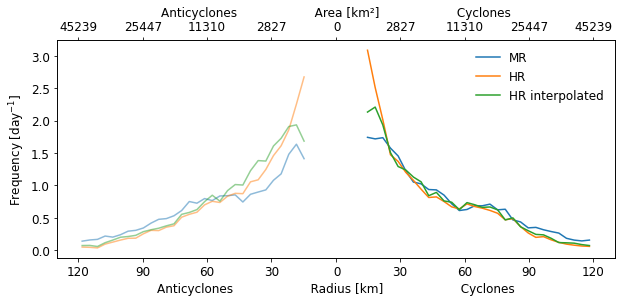

In [9]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(10, 4))

for i, run in enumerate(['pactcs30', 'pactcs15', 'pactcs15_30']):
    
    # create mask
    mcyc = np.logical_and(re_cyc[run] == 2, re_mask[run])
    mant = np.logical_and(re_cyc[run] == 1, re_mask[run])
        
    # count number of days contributing
    num_days = np.count_nonzero(re_doys[run] >= 0)
    
    # get histograms
    a = re_radius[run]
    hist_cyc, bin_edges_cyc = np.histogram(a[mcyc], bins=30, range=(13, 120), density=False)
    hist_ant, bin_edges_ant = np.histogram(a[mant], bins=30, range=(13, 120), density=False)
    
    
    def plot_hist_y(hist, bin_edges, alpha, label='', ls='-'):
        
        bin_width = bin_edges[1] - bin_edges[0]
        bar_locs = bin_edges[:-1] + 0.5*bin_width
        # normalize by num_days to get per day
        ax.plot(bar_locs, hist/num_days, color='C{:d}'.format(i), alpha=alpha, label=label, ls=ls)
    
    # plot cyclones to right
    plot_hist_y(hist_cyc, bin_edges_cyc, 1, NAMES[run])
    # plot anticyclones to left
    plot_hist_y(hist_ant, -bin_edges_ant, 0.5)
    
    # calculate the number of eddies smaller than 30km
    yr_sm = []
    for yr in range(3, 6):
        yr_mask = np.logical_and(re_mask[run], (re_years[run] == yr)[:, None])
        y = np.count_nonzero(a[yr_mask] <= 30)/np.count_nonzero(yr_mask)
        yr_sm.append(y)
    
    print('{:s}: {:1.3f} + {:1.3f}'.format(run, np.nanmean(yr_sm), 0.5*(np.nanmax(yr_sm) - np.nanmin(yr_sm))))
    

# ax.set_yscale('log')

ax.legend(frameon=False)

# set ticks for radius
ticks_radius = np.array([-120, -90, -60, -30, 0, 30, 60, 90, 120])
ax.set_xticks(ticks_radius)
ax.set_xticklabels(["{:2.0f}".format(abs(x)) for x in ticks_radius])
ax.set_xlabel('Anticyclones                    Radius [km]                    Cyclones')

# add a twin y axis to also show the area
ticks_area = radius_to_area(ticks_radius)
ax_r = ax.twiny()
ax_r.set_xlim(ax.get_xlim())
ax_r.set_xticks(ticks_radius)
ax_r.set_xticklabels(["{:2.0f}".format(abs(x)) for x in ticks_area])
ax_r.set_xlabel('Anticyclones                    Area [km²]                    Cyclones')

# add lavel
ax.set_ylabel('Frequency [day$^{-1}$]')

plt.savefig('figures/result_eddies_area.pdf')
plt.show()

In pactcs30 $37.0 \pm 1.2\%$ of the eddies are smaller than 30km, for pactcs15 this fraction is $59.5 \pm 1.6\%$. When interpolating pactcs15 to pactcs30, this fraction decreases to $42.6 \pm 0.1\%$.

#### As a function of distance to coast

In [10]:
# bin eddy radius by distance to coast

def bin_d2c(eddy_prop, cyc, run, num_distances=17):
    # create bin edges
    x = np.linspace(0, 1000, num_distances)
    
    # x value for results
    res_x = []
    # results
    res = []
    # uncertainty
    d_res = []
    
    # set up mask, if cyc is set add it to mask
    mask = re_mask[run]
    if cyc > 0:
        mask = np.logical_and(re_mask[run], re_cyc[run] == cyc)
    
    # loop bin edges
    for i in range(x.shape[0]-1):
        m = np.logical_and(mask, np.logical_and(
            re_d2coast[run] >= x[i],
            re_d2coast[run] < x[i+1],
        ))
        res.append(np.nanmean(eddy_prop[run][m]))
        
        all_res = [
            np.nanmean(eddy_prop[run][np.logical_and(
                m, (re_years[run] == yr)[:, None]
            )]) for yr in range(3, 6)
        ]
        d_res.append(
            0.5*(np.nanmax(all_res, axis=0) - np.nanmin(all_res, axis=0))
        )
        
        res_x.append((x[i]+x[i+1])/2)
    return np.array(res_x), np.array(res), np.array(d_res)
                
# calculate the radius as a function of distance to coast
# for all mesoscale eddies (differences between cyclones and anticyclones minor)
radius_all = {
    name: bin_d2c(re_radius, 0, name) for name in re_radius
}

/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater_equal
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


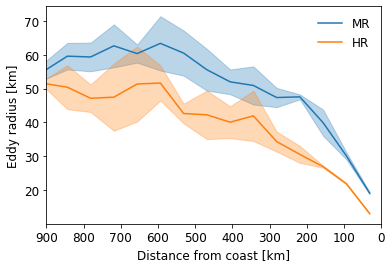

In [11]:
# plot the radius as a function of distance to coast
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i, run in enumerate(ORDER):
    # plot data...
    ax.plot(radius_all[run][0], radius_all[run][1], color='C{:d}'.format(i), label=NAMES[run])
    # ... and error
    ax.fill_between(radius_all[run][0], radius_all[run][1]+radius_all[run][2], radius_all[run][1]-radius_all[run][2], color='C{:d}'.format(i), alpha=0.3)

# reverse
ax.set_xlim(900, 0)
    
# labels
ax.legend(frameon=False, loc=1)
ax.set_ylabel('Eddy radius [km]')
ax.set_xlabel('Distance from coast [km]')

plt.savefig('figures/result_eddies_d2c.pdf')
plt.show()

In [12]:
# distances are 31, 280 and 840km
print(radius_all[run][0][np.array([0, 3, 13])])

for run in ['pactcs30', 'pactcs15']:
    # get values at these points
    l_30 = radius_all[run][1][0]
    l_220 = radius_all[run][1][3]
    l_840 = radius_all[run][1][11]
    
    # print values and the relative change
    print(run)
    print('\tRadius at 30km: {:2.2f}'.format(l_30))
    print('\tRadius at 220km: {:2.2f}'.format(l_220))
    print('\tRadius at 840km: {:2.2f}'.format(l_840))
    print('\tRadius between 220 and 840km: {:2.2f}'.format(np.nanmean(radius_all[run][1][3:13])))
    print('\tIncrease from 30km to 220km: {:1.3f}'.format(l_30/l_220))
    print('\tIncrease from 220km to 840km: {:1.3f}'.format(l_220/l_840))
    

[ 31.25 218.75 843.75]
pactcs30
	Radius at 30km: 19.11
	Radius at 220km: 47.55
	Radius at 840km: 62.62
	Radius between 220 and 840km: 55.95
	Increase from 30km to 220km: 0.402
	Increase from 220km to 840km: 0.759
pactcs15
	Radius at 30km: 13.08
	Radius at 220km: 30.55
	Radius at 840km: 47.46
	Radius between 220 and 840km: 42.93
	Increase from 30km to 220km: 0.428
	Increase from 220km to 840km: 0.644


### Track Lifetime

In [13]:
# define the threshold for long living tracks
track_long_lived = 90

In [14]:
def get_tracks_with_min(min_lifetime=0):
    """
    Get all tracks with a minimum lifetime of min_lifetime and which are at least 5 times in the subdomain.
    """
    tracks = {}
    for name in runs:
        k = []
        for t in np.unique(re_tidx[name]):  # loop each track
            m = re_tidx[name] == t  # set up an eddy boolean mask for this track
            m[:364, :] = False  # make sure the first two years...
            m[910:, :] = False  # and everything after five years is dropped
            
            # if we have frames, the lifetime is larger than min_lifetime and the track is inside the domain for at least 5 snapshots
            if np.count_nonzero(m) > 0 and re_lifetime[name][m][0] > min_lifetime and np.count_nonzero(re_mask[name][m]) > 5:
                # append track id
                k.append(t)
        # as numpy array
        tracks[name] = np.array(k)
    return tracks

# get all tracks with a minimum lifetime of 4 days
tracks = get_tracks_with_min(min_lifetime=4)

# split to cyclones...
tracks_cycl = {
    name: np.array([t for t in tracks[name] if (re_cyc[name][re_tidx[name] == t] == 2).all()]) for name in tracks
}

# ... and anticyclones
tracks_anti = {
    name: np.array([t for t in tracks[name] if (re_cyc[name][re_tidx[name] == t] == 1).all()]) for name in tracks
}

In [15]:
# get the lifetime of each identified track
track_lifetime_cyclones = {
    name: np.array([re_lifetime[name][re_tidx[name] == t][0]  for t in tracks_cycl[name]]) for name in runs
}

track_lifetime_anticyclones = {
    name: np.array([re_lifetime[name][re_tidx[name] == t][0]  for t in tracks_anti[name]]) for name in runs
}

In [16]:
# print lifetime and long-living tracks

for i, run in enumerate(ORDER):
    
    print(run)
    
    # calculate mean lifetime...
    mlftcyc = np.mean(track_lifetime_cyclones[run].astype(float))
    mlftant = np.mean(track_lifetime_anticyclones[run].astype(float))
    # ... and the error
    d_mlftcyc = np.std(track_lifetime_cyclones[run].astype(float))
    d_mlftant = np.std(track_lifetime_anticyclones[run].astype(float))
    
    # calculate the number of long living cyclones
    num_long_liv_cyc = np.count_nonzero(track_lifetime_cyclones[run] >= track_long_lived)
    # ... and anticyclones
    num_long_liv_ant = np.count_nonzero(track_lifetime_anticyclones[run] >= track_long_lived)
    
    print('\tCyclones: {:2.2f} + {:2.2f} ({:d})'.format(mlftcyc, d_mlftcyc, num_long_liv_cyc))
    print('\tAnticyclones: {:2.2f} + {:2.2f} ({:d})'.format(mlftant, d_mlftant, num_long_liv_ant))

pactcs30
	Cyclones: 83.22 + 112.41 (113)
	Anticyclones: 69.68 + 100.03 (95)
pactcs15
	Cyclones: 58.07 + 96.14 (115)
	Anticyclones: 48.91 + 70.68 (83)


### Track Speed

In [17]:
# get lifetime of all tracks
track_lifetime = {
    name: np.array([re_lifetime[name][re_tidx[name] == t][0]  for t in tracks[name]]) for name in runs
}

# get distance for all tracks
track_distances = {
    name: np.array([re_d2coast[name][re_tidx[name] == t][-1] - re_d2coast[name][re_tidx[name] == t][0] for t in tracks[name]]) for name in runs
}

# calculate the speed for all tracks
track_speed = {
    name: track_distances[name]/track_lifetime[name] for name in track_distances
}

In [18]:
# print speed
for run in ORDER:
    
    speed = np.nanmean(track_speed[run])
    d_speed = np.nanstd(track_speed[run])
    
    print('{:s}: {:1.3f} + {:1.3f}'.format(run, speed, d_speed))

pactcs30: 1.096 + 1.755
pactcs15: 0.881 + 1.946


The speed of mesoscale eddies is around 1km/day.

### Ratio Cyclonic to Anticyclonic tracks

In [19]:
# In order to calculate an interannual variability, we need to assign the tracks to a specific year
# the year of a track is defined as the year in which most of the track lies

def get_track_year(name, track_id):
    mask = np.logical_and(re_tidx[name] == track_id, re_mask[name])
    mask = np.sum(mask, axis=1) > 0
    years = re_years[name][mask]
    val, counts = np.unique(years, return_counts=True)
    return val[np.argmax(counts)]


# calculate the year for cyclones...
track_year_cyclones = {
    name: np.array([get_track_year(name, t) for t in tracks_cycl[name]]) for name in runs
}

# and anticyclones
track_year_anticyclones = {
    name: np.array([get_track_year(name, t) for t in tracks_anti[name]]) for name in runs
}

In [20]:
# loop from a minimal threshold of 0 days lifetime to 150 days lifetime with a stepsize of 5 days
step = 5
lifetime_thresholds = np.arange(0, 150, step)

# store results
num_lft_cycl = {}
num_lft_anti = {}


for i, run in enumerate(ORDER):
    # create arrays
    y_cycl = []
    y_anti = []
    # loop thresholds of minimum lifetimes
    for threshold in lifetime_thresholds:
        # get the number of cyclones for each year that have a lifetime larger than threshold
        yrs_cycl = [
            np.count_nonzero(
                track_lifetime_cyclones[run][track_year_cyclones[run] == yr] >= threshold
            ) for yr in range(3, 6)
        ]
        # get the number of anticyclones for each year that have a lifetime larger than threshold
        yrs_anti = [
            np.count_nonzero(
                track_lifetime_anticyclones[run][track_year_anticyclones[run] == yr] >= threshold
            ) for yr in range(3, 6)
        ]
        # append mean value and interannual variability for cyclones...
        y_cycl.append(
            (np.nanmean(yrs_cycl), 0.5*(np.nanmax(yrs_cycl) - np.nanmin(yrs_cycl)))
        )
        # ... and anticyclones
        y_anti.append(
            (np.nanmean(yrs_anti), 0.5*(np.nanmax(yrs_anti) - np.nanmin(yrs_anti)))
        )
        
    # convert to numpy
    num_lft_cycl[run] = np.array(y_cycl)
    num_lft_anti[run] = np.array(y_anti)

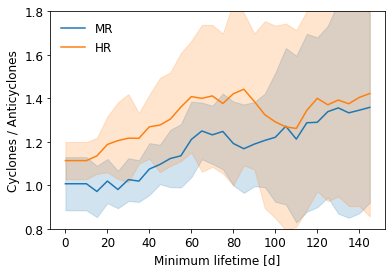

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# calculate the ratio of cyclones/anticyclones for pactcs30...
num_rel_30, d_num_rel_30 = ratio_with_error(
    num_lft_cycl['pactcs30'][:, 0], 
    num_lft_anti['pactcs30'][:, 0],
    num_lft_cycl['pactcs30'][:, 1], 
    num_lft_anti['pactcs30'][:, 1]
)

# ... and pactcs15
num_rel_15, d_num_rel_15 = ratio_with_error(
    num_lft_cycl['pactcs15'][:, 0], 
    num_lft_anti['pactcs15'][:, 0],
    num_lft_cycl['pactcs15'][:, 1], 
    num_lft_anti['pactcs15'][:, 1]
)

# plot pactcs30
ax.plot(lifetime_thresholds, num_rel_30, label='MR', color='C0')
ax.fill_between(lifetime_thresholds, num_rel_30 - d_num_rel_30, num_rel_30 + d_num_rel_30, color='C0', alpha=0.2)

# plot pactcs15
ax.plot(lifetime_thresholds, num_rel_15, label='HR', color='C1')
ax.fill_between(lifetime_thresholds, num_rel_15 - d_num_rel_15, num_rel_15 + d_num_rel_15, color='C1', alpha=0.2)

# shrink size as the error gets very large for larger thresholds
ax.set_ylim(0.8, 1.8)

# labels
ax.set_xlabel('Minimum lifetime [d]')
ax.set_ylabel('Cyclones / Anticyclones')
ax.legend(frameon=False, loc=2)

plt.savefig('figures/result_eddies_lft_tracks.pdf')
plt.show()

## Density Anomaly

In [22]:
# load data
mean_rho_pxcycl = {
    name: runs_rho[name]['tot_diff_rho_pxcycl_mean'].values for name in runs_rho
}
mean_rho_pxanti = {
    name: runs_rho[name]['tot_diff_rho_pxanti_mean'].values for name in runs_rho
}

In [23]:
def timeseries_to_doyseries(data, times):
    """
    Function to convert a timeseries (5 * 182 days) to a doy series (182 doy, average over the years).
    The error is estimated from interannual variability.
    """
    
    # make sure times matches data
    assert data.shape[0] == times.shape[0], (data.shape, times.shape)
    
    res = defaultdict(list)
    d_res = defaultdict(list)
    
    # loop times
    for time_index in range(times.shape[0]):
        # get doy
        tobj = times[time_index]
        
        # skip first two years
        if tobj.year < 3 or tobj.year > 5:
            continue
        
        # get doy
        doy = tobj.dayofyr - 1
        doy = doy - (doy%2)  # fix bidaily stuff
        
        # get data
        td = data[time_index]
        
        # append to dict with key doy
        if not np.isnan(td).all():
            res[doy].append(td)
    
    r = []
    d_r = []
    doys = []
    # loop possible doys
    for doy in range(365):
        if doy in res: # if this doy appeared
            # get mean
            r.append(np.nanmean(res[doy], axis=0))
            # get interannual variability
            d_r.append(0.5*np.abs(
                np.nanmax(res[doy], axis=0) - np.nanmin(res[doy], axis=0)
            ))
            # save that this doy appeared
            doys.append(doy)
            
    return np.array(doys), np.array(r), np.array(d_r)

In [24]:
def doyseries_to_season(doys, data, stds, d2c_slice, num_seasons=4):
    """
    Reduce doy series to a given number of seasons (by averaging). The Error is propagated accordingly.
    """
    
    assert data.shape[0] == 182
    step = data.shape[0] // num_seasons
    
    season_data = []
    season_d_data = []
    
    for i in range(num_seasons):
        # slice data
        d = data[i*step:(i+1)*step, d2c_slice].reshape(-1)
        dd = stds[i*step:(i+1)*step, d2c_slice].reshape(-1)
        # get mean and error
        mean, d_mean = mean_with_error(d, dd)
        season_data.append(mean)
        season_d_data.append(d_mean)
    
    return np.array(season_data), np.array(season_d_data)

In [25]:
# get doy series
doy_mean_rho_pxcycl = {
    name: timeseries_to_doyseries(mean_rho_pxcycl[name], runs_rho[name].time.values) for name in mean_rho_pxcycl
} 
doy_mean_rho_pxanti = {
    name: timeseries_to_doyseries(mean_rho_pxanti[name], runs_rho[name].time.values) for name in mean_rho_pxanti
}

/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: All-NaN axis encountered


In [26]:
# define number of seasons to consider
num_seasons = 8

In [27]:
# convert doy series to seasons for the offshore region

# ... for cyclones
rho_cycl_30, d_rho_cycl_30 = doyseries_to_season(*doy_mean_rho_pxcycl['pactcs30'], d2c_slice=slice(10, 40), num_seasons=num_seasons)
rho_cycl_15, d_rho_cycl_15 = doyseries_to_season(*doy_mean_rho_pxcycl['pactcs15'], d2c_slice=slice(10, 40), num_seasons=num_seasons)

# ... for anticyclones
rho_anti_30, d_rho_anti_30 = doyseries_to_season(*doy_mean_rho_pxanti['pactcs30'], d2c_slice=slice(10, 40), num_seasons=num_seasons)
rho_anti_15, d_rho_anti_15 = doyseries_to_season(*doy_mean_rho_pxanti['pactcs15'], d2c_slice=slice(10, 40), num_seasons=num_seasons)

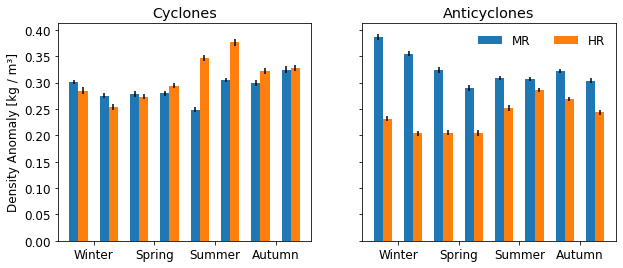

In [28]:
# plot data

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# location of bars
loc_15 = np.arange(num_seasons) + 0.15
loc_30 = np.arange(num_seasons) - 0.15
# width of bars
width = 0.3

# plot data
ax[0].bar(loc_30, rho_cycl_30, color='C0', width=width, label=NAMES['pactcs30'], yerr=d_rho_cycl_30)
ax[0].bar(loc_15, rho_cycl_15, color='C1', width=width, label=NAMES['pactcs15'], yerr=d_rho_cycl_15)
ax[1].bar(loc_30, -rho_anti_30, color='C0', width=width, label=NAMES['pactcs30'], yerr=d_rho_anti_30)
ax[1].bar(loc_15, -rho_anti_15, color='C1', width=width, label=NAMES['pactcs15'], yerr=d_rho_anti_15)
    
# x axis
xticks = [0.5, 2.5, 4.5, 6.5]
xticklabels = ['Winter', 'Spring', 'Summer', 'Autumn']
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticklabels)
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xticklabels)

# y axis
ax[0].set_ylabel('Density Anomaly [kg / m³]')

# labels
ax[1].legend(frameon=False, ncol=2)
ax[0].set_title('Cyclones')
ax[1].set_title('Anticyclones')

plt.savefig('figures/result_eddies_density.pdf')
plt.show()

#### Some exact values from the plot

In [29]:
# Print exact values for winter, anticyclones
print(rho_anti_15[:2].mean(), d_rho_anti_15[:2].max())
print(rho_anti_30[:2].mean(), d_rho_anti_30[:2].max())

# Print exact values for late winter and late summer, cyclones
print(rho_cycl_15[1], d_rho_cycl_15[1])
print(rho_cycl_15[5], d_rho_cycl_15[5])

-0.21762085870466158 0.005333838508735317
-0.37109081292892754 0.0056112368749697905
0.25402682506288765 0.005568633848752247
0.37647118541940505 0.006058009346458761


During winter, the anomaly of anticyclones drops from $-0.371 \pm 0.006$ in MR to $-0.218 \pm 0.005$ in HR. Cyclones in HR intensify from $-0.254 \pm 0.06$ in late winter to $0.376 \pm 0.006$ in late summer.

#### Same procedure for different averaging

/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: All-NaN axis encountered


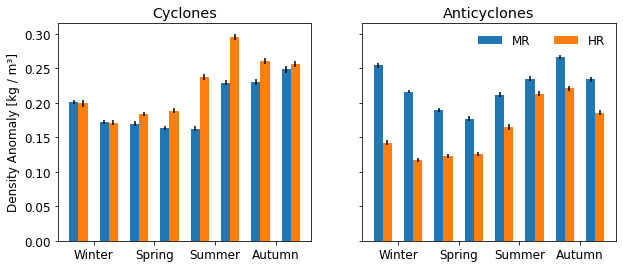

In [30]:
# load data
mean_rho2_pxcycl = {
    name: runs_rho2[name]['tot_diff_rho_pxcycl_mean'].values for name in runs_rho
}
mean_rho2_pxanti = {
    name: runs_rho2[name]['tot_diff_rho_pxanti_mean'].values for name in runs_rho
}

# get doy series
doy_mean_rho2_pxcycl = {
    name: timeseries_to_doyseries(mean_rho2_pxcycl[name], runs_rho2[name].time.values) for name in mean_rho2_pxcycl
} 
doy_mean_rho2_pxanti = {
    name: timeseries_to_doyseries(mean_rho2_pxanti[name], runs_rho2[name].time.values) for name in mean_rho2_pxanti
}

# convert doy series to seasons for the offshore region

# ... for cyclones
rho2_cycl_30, d_rho2_cycl_30 = doyseries_to_season(*doy_mean_rho2_pxcycl['pactcs30'], d2c_slice=slice(10, 40), num_seasons=num_seasons)
rho2_cycl_15, d_rho2_cycl_15 = doyseries_to_season(*doy_mean_rho2_pxcycl['pactcs15'], d2c_slice=slice(10, 40), num_seasons=num_seasons)

# ... for anticyclones
rho2_anti_30, d_rho2_anti_30 = doyseries_to_season(*doy_mean_rho2_pxanti['pactcs30'], d2c_slice=slice(10, 40), num_seasons=num_seasons)
rho2_anti_15, d_rho2_anti_15 = doyseries_to_season(*doy_mean_rho2_pxanti['pactcs15'], d2c_slice=slice(10, 40), num_seasons=num_seasons)

# plot data

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# location of bars
loc_15 = np.arange(num_seasons) + 0.15
loc_30 = np.arange(num_seasons) - 0.15
# width of bars
width = 0.3

# plot data
ax[0].bar(loc_30, rho2_cycl_30, color='C0', width=width, label=NAMES['pactcs30'], yerr=d_rho2_cycl_30)
ax[0].bar(loc_15, rho2_cycl_15, color='C1', width=width, label=NAMES['pactcs15'], yerr=d_rho2_cycl_15)
ax[1].bar(loc_30, -rho2_anti_30, color='C0', width=width, label=NAMES['pactcs30'], yerr=d_rho2_anti_30)
ax[1].bar(loc_15, -rho2_anti_15, color='C1', width=width, label=NAMES['pactcs15'], yerr=d_rho2_anti_15)
    
# x axis
xticks = [0.5, 2.5, 4.5, 6.5]
xticklabels = ['Winter', 'Spring', 'Summer', 'Autumn']
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticklabels)
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xticklabels)

# y axis
ax[0].set_ylabel('Density Anomaly [kg / m³]')

# labels
ax[1].legend(frameon=False, ncol=2)
ax[0].set_title('Cyclones')
ax[1].set_title('Anticyclones')

plt.savefig('figures/result_eddies_density2.pdf')
plt.show()

## Eddy Kinetic Energy

In [31]:
# load the overall EKE (independent from eddy detections)
eke_t = {}

# set up bins to bin the data
distances = np.linspace(0, 1000, 51)

def get_binned_eke(run, eke):
    assert eke.shape[0] == 182
    # create result object
    res = np.zeros((182, distances.shape[0]-1)).astype(float)
    # loop distance to coast bins
    for i in range(distances.shape[0]-1):
        # create a mask regarding distance to coast
        m = np.logical_and(r_distance_map[run] >= distances[i], r_distance_map[run] < distances[i+1])
        # add the subdomain to mask
        m = np.logical_and(m, r_gruber_mask[run])
        # calculate the mean, only use every second day as bidaily
        res[:, i] = np.nanmean(eke[:, m], axis=1)
    return res

# dictionary for resulting data and interannual variability
eke_maps = {}
d_eke_maps = {}

for run in ['pactcs30', 'pactcs15']:
    # load data
    data = xr.open_dataset('/nfs/kryo/work/maxsimon/data/'+run+'/z/eke.nc')
    eke = data.eke
    
    # get eke for every year
    eke_yr3 = get_binned_eke(run, eke.isel(time=slice(2*182,3*182)).values)
    eke_yr4 = get_binned_eke(run, eke.isel(time=slice(3*182,4*182)).values)
    eke_yr5 = get_binned_eke(run, eke.isel(time=slice(4*182,5*182)).values)
    eke_t = (eke_yr3, eke_yr4, eke_yr5)
    
    eke_maps[run] = np.nanmean(eke_t, axis=0)
    d_eke_maps[run] = 0.5 * np.abs(np.nanmax(eke_t, axis=0) - np.nanmin(eke_t, axis=0))

/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


In [32]:
# load EKE associated to eddy detections
mean_ke_pxcycl = {
    name: runs_ke[name]['tot_diff_eke_pxcycl_mean'].values for name in runs_ke
}
mean_ke_pxanti = {
    name: runs_ke[name]['tot_diff_eke_pxanti_mean'].values for name in runs_ke
}

In [33]:
# get doy series
doy_mean_ke_pxcycl = {
    name: timeseries_to_doyseries(mean_ke_pxcycl[name], runs_ke[name].time.values) for name in mean_ke_pxcycl
} 
doy_mean_ke_pxanti = {
    name: timeseries_to_doyseries(mean_ke_pxanti[name], runs_ke[name].time.values) for name in mean_ke_pxanti
}

/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: All-NaN axis encountered


#### As Hovmöller diagrams

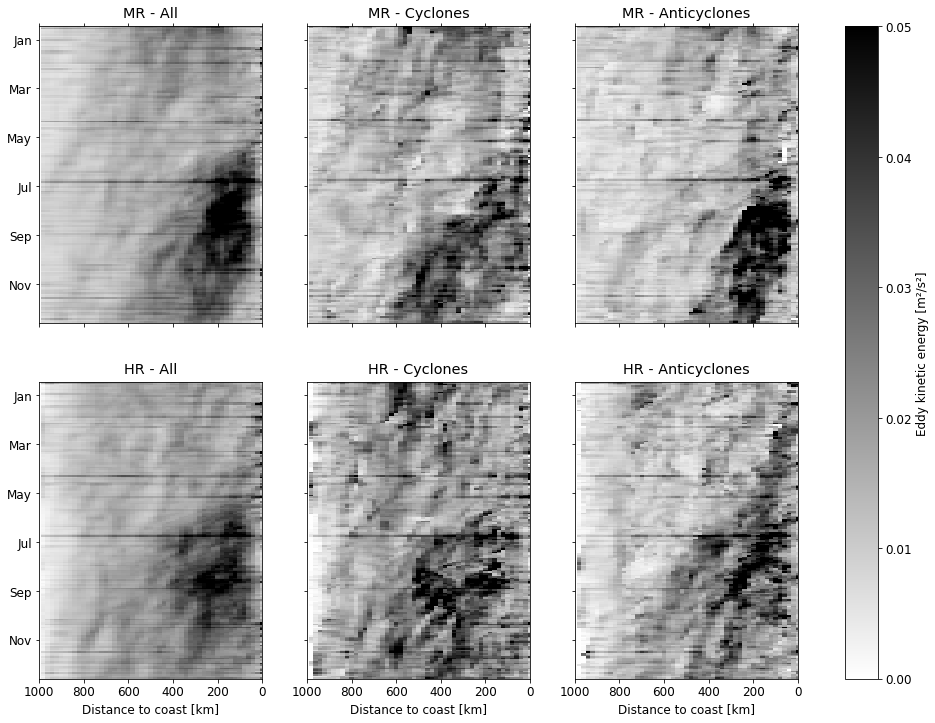

In [34]:
# plot the different the different EKEs as Hovemöller diagrams

fig, ax = plt.subplots(2, 3, figsize=(17, 12), sharey='row', sharex='col')
    
cax1 = None

# loop runs
for i, run in enumerate(ORDER):
    
    # set xticks to match the distance from coast with nice formatting
    def set_xticks(axi, data):
        num_x = data.shape[1]
        axi.set_xlim(num_x, 0)
        x_ticks = list(j for j in range(0, num_x+1, 10))
        distances = np.linspace(0, 1000, num_x + 1)
        axi.set_xticks(x_ticks)
        axi.set_xticklabels(["{:.0f}".format(distances[j]) for j in x_ticks])
    
    # plot the data, i.e. adjust the y ticks to Month names
    def imshow(axi, data):
        # just plot the data...
        cax = axi.matshow(data, vmin=0, vmax=5e-2, cmap='gist_gray_r', aspect='auto')
        # ... and the rest is formatting of y and x labels...
        num_x = data.shape[1]
        axi.set_xlim(num_x, 0)
        y_ticks = np.array([0, 30, 60, 90, 120, 150]) + 7.5
        axi.set_yticks(y_ticks)
        axi.set_yticklabels(["Jan", "Mar", "May", "Jul", "Sep", "Nov"])
        set_xticks(axi, data)
        return cax
    
    # plot detection-independent, cyclonic and anticyclonic eke
    cax1 = imshow(ax[i, 0], eke_maps[run])
    imshow(ax[i, 1], doy_mean_ke_pxcycl[run][1])
    imshow(ax[i, 2], doy_mean_ke_pxanti[run][1])
    
    # set titles
    ax[i, 0].set_title(NAMES[run] + ' - All', y=1.01)
    ax[i, 1].set_title(NAMES[run] + ' - Cyclones', y=1.01)
    ax[i, 2].set_title(NAMES[run] + ' - Anticyclones', y=1.01)
    
# move xaxis to bottom
for i in range(3):
    ax[1, i].xaxis.set_ticks_position('bottom')
    ax[1, i].set_xlabel('Distance to coast [km]')
    
# add colorbar
plt.colorbar(cax1, ax=ax, location='right', label='Eddy kinetic energy [m²/s²]')

plt.savefig('figures/result_eddies_eke.pdf')
plt.show()

#### Overall Increase

In [35]:
eke_rel_tot, d_eke_rel_tot = ratio_with_error(eke_maps['pactcs15'], eke_maps['pactcs30'], d_eke_maps['pactcs15'], d_eke_maps['pactcs30'])
mean_eke_rel_tot, d_mean_eke_rel_tot = mean_with_error(eke_rel_tot[:, :40], d_eke_rel_tot[:, :40])
print('Overall average increase of EKE: {:1.3f} + {:1.3f}'.format(mean_eke_rel_tot, d_mean_eke_rel_tot))

# relative increase for the different seasons
eke_rel_tot_season, d_eke_rel_tot_season = doyseries_to_season(None, eke_rel_tot, d_eke_rel_tot, d2c_slice=slice(0, 40), num_seasons=4)
print(eke_rel_tot_season, d_eke_rel_tot_season)

Overall average increase of EKE: 1.102 + 0.005
[0.99047793 1.14855997 1.14829732 1.11580866] [0.00890952 0.00998673 0.00969652 0.00967965]


#### Differences in the Nearshore Region

In [36]:
# convert doy series to seasons for the nearshore region

eke_anti_15_nearshore, d_eke_anti_15_nearshore = doyseries_to_season(*doy_mean_ke_pxanti['pactcs15'], d2c_slice=slice(0, 10), num_seasons=8)
eke_anti_30_nearshore, d_eke_anti_30_nearshore = doyseries_to_season(*doy_mean_ke_pxanti['pactcs30'], d2c_slice=slice(0, 10), num_seasons=8)

print('EKE nearshore anticyclones in March to June')
print('pactcs15: {:1.3e} + {:1.3e}'.format(*mean_with_error(doy_mean_ke_pxanti['pactcs15'][1][30:90, :10], doy_mean_ke_pxanti['pactcs15'][2][30:90, :10])))
print('pactcs30: {:1.3e} + {:1.3e}'.format(*mean_with_error(doy_mean_ke_pxanti['pactcs30'][1][30:90, :10], doy_mean_ke_pxanti['pactcs30'][2][30:90, :10])))

EKE nearshore anticyclones in March to June
pactcs15: 2.615e-02 + 4.226e-04
pactcs30: 1.832e-02 + 4.172e-04


In [37]:
# convert doy series to seasons for the nearshore region

eke_anti_15_nearshore, d_eke_anti_15_nearshore = doyseries_to_season(*doy_mean_ke_pxanti['pactcs15'], d2c_slice=slice(0, 10), num_seasons=8)
eke_anti_30_nearshore, d_eke_anti_30_nearshore = doyseries_to_season(*doy_mean_ke_pxanti['pactcs30'], d2c_slice=slice(0, 10), num_seasons=8)

print('EKE nearshore in February and March')
print('pactcs15: {:1.3e} + {:1.3e}'.format(eke_anti_15_nearshore[2:4].mean(), d_eke_anti_15_nearshore[2:4].max()))
print('pactcs30: {:1.3e} + {:1.3e}'.format(eke_anti_30_nearshore[2:4].mean(), d_eke_anti_30_nearshore[2:4].max()))

print('EKE nearshore')
print('pactcs15: {:1.3e} + {:1.3e}'.format(*mean_with_error(eke_anti_15_nearshore[2:8], d_eke_anti_15_nearshore[2:8])))
print('pactcs30: {:1.3e} + {:1.3e}'.format(*mean_with_error(eke_anti_30_nearshore[2:8], d_eke_anti_30_nearshore[2:8])))

EKE nearshore in February and March
pactcs15: 2.661e-02 + 7.426e-04
pactcs30: 1.775e-02 + 7.120e-04
EKE nearshore
pactcs15: 2.747e-02 + 3.798e-04
pactcs30: 2.813e-02 + 5.647e-04


#### Differences in the Offshore Region

In [38]:
# convert doy series to seasons for the offshore region

# ... for cyclones
eke_cycl_30, d_eke_cycl_30 = doyseries_to_season(*doy_mean_ke_pxcycl['pactcs30'], d2c_slice=slice(10, 40), num_seasons=8)
eke_cycl_15, d_eke_cycl_15 = doyseries_to_season(*doy_mean_ke_pxcycl['pactcs15'], d2c_slice=slice(10, 40), num_seasons=8)

# ... for anticyclones
eke_anti_30, d_eke_anti_30 = doyseries_to_season(*doy_mean_ke_pxanti['pactcs30'], d2c_slice=slice(10, 40), num_seasons=8)
eke_anti_15, d_eke_anti_15 = doyseries_to_season(*doy_mean_ke_pxanti['pactcs15'], d2c_slice=slice(10, 40), num_seasons=8)

In [39]:
# calculate relative increase for cyclones and anticyclones
eke_rel_cycl, d_eke_rel_cycl = ratio_with_error(eke_cycl_15, eke_cycl_30, d_eke_cycl_15, d_eke_cycl_30)
eke_rel_anti, d_eke_rel_anti = ratio_with_error(eke_anti_15, eke_anti_30, d_eke_anti_15, d_eke_anti_30)

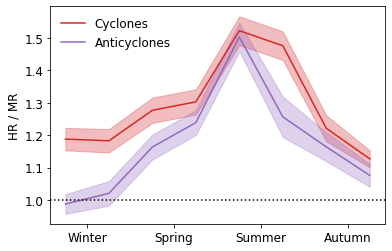

In [40]:
fig, ax = plt.subplots(1, 1)

# well...
x = [0, 1, 2, 3, 4, 5, 6, 7]

# plot data with error for cyclones
ax.plot(x, eke_rel_cycl, color='C3', label='Cyclones')
ax.fill_between(x, eke_rel_cycl-d_eke_rel_cycl, eke_rel_cycl+d_eke_rel_cycl, color='C3', alpha=0.3)
# plot data with error for anticyclones
ax.plot(x, eke_rel_anti, color='C4', label='Anticyclones')
ax.fill_between(x, eke_rel_anti-d_eke_rel_anti, eke_rel_anti+d_eke_rel_anti, color='C4', alpha=0.3)

# add a horizontal line for better comparison
ax.axhline(1, color='k', ls=':')

# x axis
xticks = [0.5, 2.5, 4.5, 6.5]
xticklabels = ['Winter', 'Spring', 'Summer', 'Autumn']
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# y axis
ax.set_ylabel('HR / MR')

# label
ax.legend(frameon=False)

plt.savefig('figures/result_eddies_eke_comparison.pdf')
plt.show()